# Import Function

In [87]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_fscore_support, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split

from gensim.utils import tokenize
from gensim.parsing.preprocessing import remove_stopwords, strip_short, strip_tags, strip_punctuation, preprocess_string, strip_numeric,strip_multiple_whitespaces
from gensim import models
from gensim import corpora
import gensim.downloader

from nltk.corpus import wordnet
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings("ignore")

In [18]:
def format_spines(ax, right_border=True):
    """docstring for format_spines:
    this function sets up borders from an axis and personalize colors
    input:
        ax: figure axis
        right_border: flag to determine if the right border will be visible or not"""
    
    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_color('#FFFFFF')
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    
def count_plot(feature, df, colors='Blues_d', hue=False):
    """docstring for count_plot:
    this function plots data setting up frequency and percentage. This algo sets up borders
    and personalization
    input:
        feature: feature to be plotted
        df: dataframe
        colors = color palette (default=Blues_d)
        hue = second feature analysis (default=False)"""
    
    # Preparing variables
    ncount = len(df)
    fig, ax = plt.subplots()
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors)

    # Make twin axis
    ax2=ax.twinx()

    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    # Also switch the labels over
    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    # Setting borders
    format_spines(ax)
    format_spines(ax2)

    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)
        
    plt.show()

In [19]:
from wordcloud import WordCloud, STOPWORDS


def plot_wordcloud(wordcloud):
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

def wordcloud_from_sentences(sentences):
    comment_words = '' 
    stopwords = set(STOPWORDS)

    # iterate through the csv file 
    for val in sentences: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(
        width = 800, 
        height = 800, 
        background_color ='white',             
        stopwords = stopwords, 
        min_font_size = 10
    ).generate(comment_words)
    
    plot_wordcloud(wordcloud=wordcloud)

# Dataframe Analysis

In [20]:
covid = pd.read_csv("Corona_NLP_test.csv")

In [24]:
#Removes link to tweet

length = len(covid['OriginalTweet'])
for i in range(length):
    covid['OriginalTweet'][i] =  re.sub(r"http\S+", "", covid['OriginalTweet'][i], flags=re.MULTILINE)

In [ ]:
#Drops unwanted columns

covid = covid.drop(['UserName','ScreenName','Location','TweetAt'], axis=1)

In [7]:
covid.shape 

(3798, 2)

## Feature Creation

In [27]:
covid['hashtag']  = covid['OriginalTweet'].str.count('#')

In [122]:
covid['count']  = covid['OriginalTweet'].str.split().str.len()

In [29]:
covid['mentions']  = covid['OriginalTweet'].str.count('@')

In [11]:
covid.head()

,OriginalTweet,Sentiment,hashtag,count,mentions
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,1,21,0
1,When I couldn't find hand sanitizer at Fred Me...,Positive,2,29,0
2,Find out how you can protect yourself and love...,Extremely Positive,1,13,0
3,#Panic buying hits #NewYork City as anxious sh...,Negative,11,35,0
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,11,25,0


## Example Tweets

In [110]:
covid['OriginalTweet'][covid['Sentiment'] == "Positive"][1]

"When I couldn't find hand sanitizer at Fred Meyer, I turned to #Amazon. But $114.97 for a 2 pack of Purell??!!Check out how  #coronavirus concerns are driving up prices. "

In [113]:
covid['OriginalTweet'][covid['Sentiment'] == "Extremely Positive"][2]

'Find out how you can protect yourself and loved ones from #coronavirus. ?'

In [115]:
covid['OriginalTweet'][covid['Sentiment'] == "Extremely Negative"][8]

'HI TWITTER! I am a pharmacist. I sell hand sanitizer for a living! Or I do when any exists. Like masks, it is sold the fuck out everywhere. SHOULD YOU BE WORRIED? No. Use soap. SHOULD YOU VISIT TWENTY PHARMACIES LOOKING FOR THE LAST BOTTLE? No. Pharmacies are full of sick people.'

In [119]:
covid['OriginalTweet'][covid['Sentiment'] == "Negative"][3770]

"PSA: Stop panicking about COVID-19, you don't need to shelter yourselves from the outside world and stock up on toilet paper and food enough to stuff Old Faithful 10x over. If you want to go out and shop, go out and shop! If you want to go and eat, go and eat! It's not malaria!"

In [121]:
covid['OriginalTweet'][covid['Sentiment'] == "Neutral"][5]

'Do you remember the last time you paid $2.99 a gallon for regular gas in Los Angeles?Prices at the pump are going down. A look at how the #coronavirus is impacting prices. 4pm @ABC7 '

In [30]:
# REMOVE NaN VALUES AND EMPTY STRINGS:
covid['OriginalTweet'].dropna(inplace=True)

In [31]:
covid.shape #None of the stings are empty or have NaN

(3798, 5)

## Count Analysis

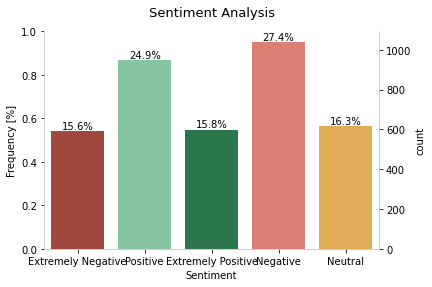

In [123]:
palette ={"Extremely Positive": "#1E8449", "Positive": "#7DCEA0", "Neutral": "#F5B041", "Extremely Negative": "#B03A2E", "Negative": "#EC7063"}
count_plot(feature='Sentiment', df=covid, colors=palette)

The data majority of negative and positive reviews, with fewer reviews being neutral and on the extreme ends.

In [33]:
covid['count'].describe()

count    3798.000000
mean       32.431016
std        11.913562
min         2.000000
25%        23.000000
50%        34.000000
75%        42.000000
max        62.000000
Name: count, dtype: float64

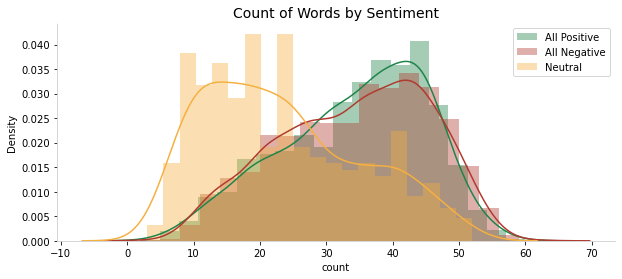

In [127]:
#All Sentiments

pos = ['Positive', 'Extremely Positive']
neg = ['Negative', 'Extremely Negative']

fig, ax = plt.subplots(figsize=(10, 4), sharex=True)
positive = covid.loc[covid['Sentiment'].isin(pos)]
negative = covid.loc[covid['Sentiment'].isin(neg)]
neutral = covid.loc[covid['Sentiment'] == 'Neutral']
ax = sns.distplot(positive['count'], bins=20, label='All Positive', 
                  color='#1E8449', hist=True)
ax = sns.distplot(negative['count'], bins=20, label='All Negative', color = "#B03A2E", 
                  hist=True)
ax = sns.distplot(neutral['count'], bins=20, label='Neutral', color = "#F5B041",
                hist=True)
ax.set_title('Count of Words by Sentiment', size=14)
format_spines(ax, right_border=False)
plt.legend()
plt.show()

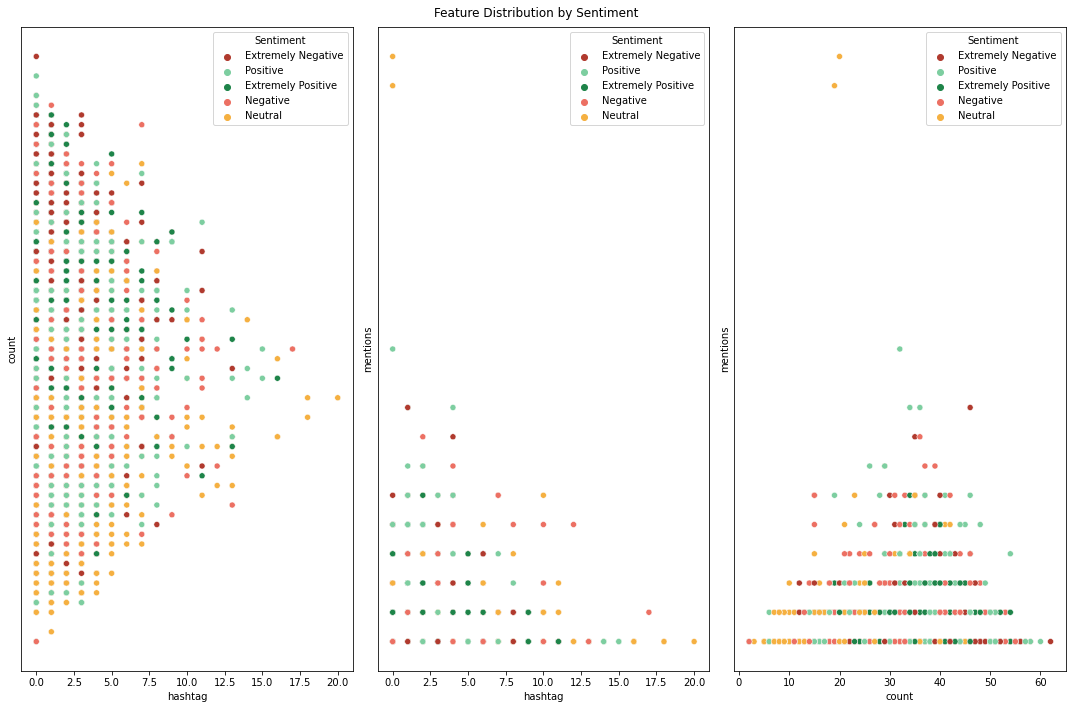

In [128]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

palette ={"Extremely Positive": "#1E8449", "Positive": "#7DCEA0", "Neutral": "#F5B041", "Extremely Negative": "#B03A2E", "Negative": "#EC7063"}

axes[0]= sns.scatterplot('hashtag', 'count', hue='Sentiment', palette=palette, data=covid, ax=axes[0]);
axes[1] = sns.scatterplot('hashtag', 'mentions', hue='Sentiment', palette=palette, data=covid, ax=axes[1]);
axes[2] = sns.scatterplot('count', 'mentions', hue='Sentiment', palette=palette, data=covid, ax=axes[2]);

fig.suptitle('Feature Distribution by Sentiment')
plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()
#plt.savefig('sctr_gender.png')

# Pre-Processing

In [129]:
tweets = covid['OriginalTweet']
filters = [lambda x: x.lower(), remove_stopwords, strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces, strip_short]
tokens = [preprocess_string(doc, filters) for doc in tweets]

In [38]:
tokens

[['trending',
  'new',
  'yorkers',
  'encounter',
  'supermarket',
  'shelves',
  'pictured',
  'wegmans',
  'brooklyn',
  'sold',
  'out',
  'online',
  'grocers',
  'foodkick',
  'maxdelivery',
  'coronavirus',
  'fearing',
  'shoppers',
  'stock'],
 ['couldn',
  'hand',
  'sanitizer',
  'fred',
  'meyer',
  'turned',
  'amazon',
  'pack',
  'purell',
  'check',
  'coronavirus',
  'concerns',
  'driving',
  'prices'],
 ['protect', 'loved', 'ones', 'coronavirus'],
 ['panic',
  'buying',
  'hits',
  'newyork',
  'city',
  'anxious',
  'shoppers',
  'stock',
  'food',
  'amp',
  'medical',
  'supplies',
  'healthcare',
  'worker',
  'bigapple',
  'confirmed',
  'coronavirus',
  'patient',
  'bloomberg',
  'staged',
  'event',
  'qanon',
  'qanon',
  'qanon',
  'election',
  'cdc'],
 ['toiletpaper',
  'dunnypaper',
  'coronavirus',
  'coronavirusaustralia',
  'coronavirusupdate',
  'covid',
  'news',
  'corvid',
  'newsmelb',
  'dunnypapergate',
  'costco',
  'week',
  'buying',
  'baby

In [130]:
#Check average length of words

new_count = []

length = len(tokens)
range(length)
wc = 0
for i in range(length):
    new_count.append(len(tokens[i]))
    wc = wc+len(tokens[i])

print(wc/length)

17.775934702474988


In [131]:
covid['new_count'] = new_count

In [134]:
covid = covid.drop(['count'], axis=1)

In [135]:
#Lemmatization

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [136]:
lemmatizer = WordNetLemmatizer()
tokens = [[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in doc] for doc in tokens]

In [137]:
tokens

[['trend',
  'new',
  'yorkers',
  'encounter',
  'supermarket',
  'shelf',
  'picture',
  'wegmans',
  'brooklyn',
  'sell',
  'out',
  'online',
  'grocer',
  'foodkick',
  'maxdelivery',
  'coronavirus',
  'fear',
  'shopper',
  'stock'],
 ['couldn',
  'hand',
  'sanitizer',
  'fred',
  'meyer',
  'turn',
  'amazon',
  'pack',
  'purell',
  'check',
  'coronavirus',
  'concern',
  'drive',
  'price'],
 ['protect', 'love', 'one', 'coronavirus'],
 ['panic',
  'buying',
  'hit',
  'newyork',
  'city',
  'anxious',
  'shopper',
  'stock',
  'food',
  'amp',
  'medical',
  'supply',
  'healthcare',
  'worker',
  'bigapple',
  'confirm',
  'coronavirus',
  'patient',
  'bloomberg',
  'stag',
  'event',
  'qanon',
  'qanon',
  'qanon',
  'election',
  'cdc'],
 ['toiletpaper',
  'dunnypaper',
  'coronavirus',
  'coronavirusaustralia',
  'coronavirusupdate',
  'covid',
  'news',
  'corvid',
  'newsmelb',
  'dunnypapergate',
  'costco',
  'week',
  'buying',
  'baby',
  'milk',
  'powder',
  

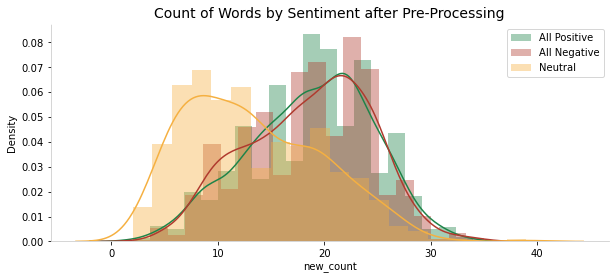

In [139]:
#All Sentiments

pos = ['Positive', 'Extremely Positive']
neg = ['Negative', 'Extremely Negative']

fig, ax = plt.subplots(figsize=(10, 4), sharex=True)
positive = covid.loc[covid['Sentiment'].isin(pos)]
negative = covid.loc[covid['Sentiment'].isin(neg)]
neutral = covid.loc[covid['Sentiment'] == 'Neutral']
ax = sns.distplot(positive['new_count'], bins=20, label='All Positive', 
                  color='#1E8449', hist=True)
ax = sns.distplot(negative['new_count'], bins=20, label='All Negative', 
                  color='#B03A2E', hist=True)
ax = sns.distplot(neutral['new_count'], bins=20, label='Neutral', 
                  color='#F5B041', hist=True)
ax.set_title('Count of Words by Sentiment after Pre-Processing', size=14)
format_spines(ax, right_border=False)
plt.legend()
plt.show()

# Supervised Learning Algorithm - Classification

## TF-IDF

In [141]:
#Create Dictionary & Corpus
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(doc) for doc in tokens]

In [56]:
#Look at Bag of Words Counts for the first document
print([[dictionary[id], freq] for id, freq in corpus[0]])

[['brooklyn', 1], ['coronaviru', 1], ['encount', 1], ['fear', 1], ['foodkick', 1], ['grocer', 1], ['maxdeliveri', 1], ['new', 1], ['onlin', 1], ['out', 1], ['pictur', 1], ['shelv', 1], ['shopper', 1], ['sold', 1], ['stock', 1], ['supermarket', 1], ['trend', 1], ['wegman', 1], ['yorker', 1]]


In [142]:
#Create TF-IDF
tfidf = models.TfidfModel(corpus)

In [143]:
#Look at TF-IDF Weights for the first document
print([[dictionary[id], np.around(freq, decimals=2)] for id, freq in tfidf[corpus][0]])

[['brooklyn', 0.28], ['coronavirus', 0.04], ['encounter', 0.3], ['fear', 0.17], ['foodkick', 0.36], ['grocer', 0.26], ['maxdelivery', 0.36], ['new', 0.16], ['online', 0.09], ['out', 0.18], ['picture', 0.24], ['sell', 0.16], ['shelf', 0.12], ['shopper', 0.2], ['stock', 0.07], ['supermarket', 0.08], ['trend', 0.25], ['wegmans', 0.28], ['yorkers', 0.32]]


In [144]:
#Turn the data into a proper matrix
def get_model_matrix(document_vector,vocabulary):

    """""

    This function helps you visualize the BoW and TFIDF models in the form of a matrix.

    """""

    my_matrix = pd.DataFrame(0.0,index = np.arange(len(document_vector)),columns=[i for i in vocabulary.values()])
    for i in range(len(document_vector)):
        for j in range(len(document_vector[i])):
            my_matrix.at[i,vocabulary[document_vector[i][j][0]]] = document_vector[i][j][1]
    my_matrix.index.name = "Doc"
    return my_matrix

In [145]:
model_df = get_model_matrix(tfidf[corpus],dictionary)

In [61]:
model_df

,brooklyn,coronaviru,encount,fear,foodkick,grocer,maxdeliveri,new,onlin,out,...,nbcphiladelphia,assum,biar,harini,lagi,mudah,rakyat,semua,tersebar,forestandpap
Doc,,,,,,,,,,,,,,,,,,,,,
0,0.282646,0.041892,0.300412,0.169697,0.361157,0.256086,0.361157,0.142786,0.091371,0.178923,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.000000,0.051810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.000000,0.123900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.000000,0.030826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.000000,0.042567,0.000000,0.000000,0.000000,0.000000,0.000000,0.145088,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,0.000000,0.065948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3795,0.000000,0.045806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.394901,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


In [62]:
#target = [1 if covid.Sentiment[i] == 'Positive' or covid.Sentiment[i] == 'Extremely Positive' or covid.Sentiment[i] == 'Neutral' else 0 for i in range(len(covid.Sentiment))]

encoding = {'Extremely Positive': 0,
            'Positive': 1,
            'Neutral': 2,
            'Negative': 3,
            'Extremely Negative': 4
           }

           
y = covid['Sentiment'].copy()
y.replace(encoding, inplace=True)


In [146]:
#Split the Data into Train / Test / Validation
X_train, X_test, y_train, y_test = train_test_split(model_df, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=99)

In [147]:
#Fit a Model
param = dict()                          # Defaults
param['objective'] = 'multi:softmax'  #
param['num_class'] = 5
param['eval_metric'] = 'auc'            #
param['learning_rate'] = 0.3            # 0.3
param['max_depth'] = 6                  # 6
param['subsample'] = 1.0                # 1.0
param['colsample_bytree'] = 1.0         # 1.0
param['colsample_bylevel'] = 1.0        # 1.0
param['reg_lambda'] = 1.0               # 1.0  (L2 regularization)
param['reg_alpha'] = 0.0                # 0.0  (L1 regularization)
param['min_split_loss'] = 0.0           # 0.0
param['min_child_weight'] = 1           # 1
param['silent'] = 1


dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = model_df.columns)
dval  = xgb.DMatrix(X_val,  label = y_val,  feature_names = model_df.columns)
evallist = [(dtrain,'train'), (dval,'validation')]

In [148]:
num_boost_round = 100
early_stopping_rounds = 20
train_monitor = dict()

model = xgb.train(param, 
                  dtrain, 
                  num_boost_round = num_boost_round,
                  evals = evallist, 
                  verbose_eval = 10,
                  early_stopping_rounds = early_stopping_rounds,
                  evals_result = train_monitor)

[17:13:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.73682	validation-auc:0.58821
[10]	train-auc:0.89133	validation-auc:0.65717
[20]	train-auc:0.93719	validation-auc:0.67732
[30]	train-auc:0.95905	validation-auc:0.68195
[40]	train-auc:0.97269	validation-auc:0.68304
[45]	train-auc:0.97697	validation-auc:0.68175


In [149]:
#Check Model Performance on the test set
dpred = xgb.DMatrix(X_test, feature_names = model_df.columns)
y_pred = model.predict(dpred)

In [150]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))


Accuracy: 0.43



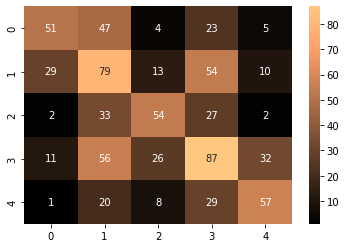

<Figure size 432x288 with 0 Axes>

In [152]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap=plt.cm.copper,fmt='g')
plt.show()
plt.savefig("cf_1.png")

## VADER - Sentiment Intensity Analyzer

Next, using VADER, we will assign scores to the Tweets, and a column to aggegrate the scores called "Compound"

In [153]:
sid = SentimentIntensityAnalyzer()

covid['scores'] = covid['OriginalTweet'].apply(lambda OriginalTweet: sid.polarity_scores(OriginalTweet))
covid['compound']  = covid['scores'].apply(lambda score_dict: score_dict['compound'])

covid.head()

,OriginalTweet,Sentiment,hashtag,mentions,new_count,scores,compound
0,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,1,0,19,"{'neg': 0.083, 'neu': 0.917, 'pos': 0.0, 'comp...",-0.2023
1,When I couldn't find hand sanitizer at Fred Me...,Positive,2,0,14,"{'neg': 0.103, 'neu': 0.897, 'pos': 0.0, 'comp...",-0.4133
2,Find out how you can protect yourself and love...,Extremely Positive,1,0,4,"{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'comp...",0.7579
3,#Panic buying hits #NewYork City as anxious sh...,Negative,11,0,26,"{'neg': 0.057, 'neu': 0.943, 'pos': 0.0, 'comp...",-0.2500
4,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,11,0,19,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000


After assigning the Compound values, since we have the sentiments associated with the tweet, we can try to label the numerical Compound value before we can run our Classification model. It is likely that we will see overlap between the sentiment compound values, but we can try our best to generalize and have discrete ranges. This will help us understand how our model may allocate sentiments

In [154]:
mod_covid = covid.drop(['OriginalTweet','scores'], axis=1)

In [96]:
mod_covid

,Sentiment,hashtag,mentions,new_count,compound
0,Extremely Negative,1,0,19,-0.2023
1,Positive,2,0,14,-0.4133
2,Extremely Positive,1,0,4,0.7579
3,Negative,11,0,26,-0.2500
4,Neutral,11,0,19,0.0000
...,...,...,...,...,...
3793,Positive,1,0,8,0.5574
3794,Negative,0,0,19,-0.2500
3795,Neutral,0,2,13,0.0000
3796,Extremely Negative,1,0,20,-0.8205


In [155]:
encoding = {'Extremely Positive': 0,
            'Positive': 1,
            'Neutral': 2,
            'Negative': 3,
            'Extremely Negative': 4
           }

           
y = covid['Sentiment'].copy()
y.replace(encoding, inplace=True)

In [156]:
#Split the Data into Train / Test / Validation

X = mod_covid.drop('Sentiment', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=99)

In [158]:
#Fit a Model
param = dict()                          # Defaults
param['objective'] = 'multi:softmax'  #
param['num_class'] = 5
param['eval_metric'] = 'auc'            #
param['learning_rate'] = 0.3            # 0.3
param['max_depth'] = 6                  # 6
param['subsample'] = 1.0                # 1.0
param['colsample_bytree'] = 1.0         # 1.0
param['colsample_bylevel'] = 1.0        # 1.0
param['reg_lambda'] = 1.0               # 1.0  (L2 regularization)
param['reg_alpha'] = 0.0                # 0.0  (L1 regularization)
param['min_split_loss'] = 0.0           # 0.0
param['min_child_weight'] = 1           # 1
param['silent'] = 1


dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = X.columns)
dval  = xgb.DMatrix(X_val,  label = y_val,  feature_names = X.columns)
evallist = [(dtrain,'train'), (dval,'validation')]

In [159]:
num_boost_round = 100
early_stopping_rounds = 20
train_monitor = dict()

model = xgb.train(param, 
                  dtrain, 
                  num_boost_round = num_boost_round,
                  evals = evallist, 
                  verbose_eval = 10,
                  early_stopping_rounds = early_stopping_rounds,
                  evals_result = train_monitor)

[17:49:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.97188	validation-auc:0.95347
[10]	train-auc:0.98914	validation-auc:0.95701
[20]	train-auc:0.99226	validation-auc:0.95736
[22]	train-auc:0.99261	validation-auc:0.95753


In [160]:
#Check Model Performance on the test set
dpred = xgb.DMatrix(X_test, feature_names = X.columns)
y_pred = model.predict(dpred)

In [161]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))


Accuracy: 0.88



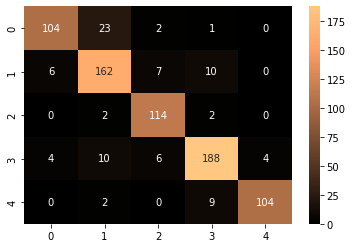

In [162]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap=plt.cm.copper,fmt='g')
plt.show()

# Supervised Learning Algorithm - Regression

In [73]:
mod_covid

,Sentiment,hashtag,mentions,new_count,compound
0,Extremely Negative,1,0,19,-0.2023
1,Positive,2,0,14,-0.4133
2,Extremely Positive,1,0,4,0.7579
3,Negative,11,0,26,-0.2500
4,Neutral,11,0,19,0.0000
...,...,...,...,...,...
3793,Positive,1,0,8,0.5574
3794,Negative,0,0,19,-0.2500
3795,Neutral,0,2,13,0.0000
3796,Extremely Negative,1,0,20,-0.8205


In [74]:
X = mod_covid.drop('Sentiment', axis=1)

def sentiment_encode(x):
    if (x == "Extremely Negative"): return -1
    if (x == "Negative"): return -0.5
    if (x == "Neutral"): return 0
    if (x == "Positive"): return 0.5
    if (x == "Extremely Positive"): return 1

label_encoded_y = list(map(sentiment_encode, mod_covid["Sentiment"]))

#Split the Data into Train / Test / Validation
X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y,test_size=0.20, random_state=42)

In [75]:
import xgboost as xgb

xgb = xgb.XGBRegressor(colsample_bytree = 0.8, #randomly select 80% of the features when training a new tree
                       learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)
xgb.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
y_pred = xgb.predict(X_train)
#print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_train, y_pred)))
print(f"RMSE Training: {mean_squared_error(y_train, y_pred,squared=False)}")

RMSE Training: 0.22660234786331585


In [79]:
y_pred = xgb.predict(X_test)
print(f"RMSE Testing: {mean_squared_error(y_test, y_pred,squared=False)}")

RMSE Testing: 0.2598918509480826


## Extra Analysis - Not included in the report

### Merging TF-IDF & Engineered Features

In [81]:
model_df['hashtag'] = mod_covid['hashtag']
model_df['mentions']= mod_covid['mentions']
model_df['new_count'] = mod_covid['new_count']
model_df['compound'] = mod_covid['compound']

In [82]:
model_df

,brooklyn,coronaviru,encount,fear,foodkick,grocer,maxdeliveri,new,onlin,out,...,biar,harini,lagi,mudah,rakyat,semua,tersebar,forestandpap,mentions,new_count
Doc,,,,,,,,,,,,,,,,,,,,,
0,0.282646,0.041892,0.300412,0.169697,0.361157,0.256086,0.361157,0.142786,0.091371,0.178923,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,19
1,0.000000,0.051810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,14
2,0.000000,0.123900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,4
3,0.000000,0.030826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,26
4,0.000000,0.042567,0.000000,0.000000,0.000000,0.000000,0.000000,0.145088,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3793,0.000000,0.065948,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,8
3794,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0,19
3795,0.000000,0.045806,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2,13


In [62]:
#target = [1 if covid.Sentiment[i] == 'Positive' or covid.Sentiment[i] == 'Extremely Positive' or covid.Sentiment[i] == 'Neutral' else 0 for i in range(len(covid.Sentiment))]

encoding = {'Extremely Positive': 0,
            'Positive': 1,
            'Neutral': 2,
            'Negative': 3,
            'Extremely Negative': 4
           }

           
y = covid['Sentiment'].copy()
y.replace(encoding, inplace=True)

In [84]:
#Split the Data into Train / Test / Validation
X_train, X_test, y_train, y_test = train_test_split(model_df, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=99)

In [88]:
#Fit a Model
param = dict()                          # Defaults
param['objective'] = 'multi:softmax'  #
param['num_class'] = 5
param['eval_metric'] = 'auc'            #
param['learning_rate'] = 0.3            # 0.3
param['max_depth'] = 6                  # 6
param['subsample'] = 1.0                # 1.0
param['colsample_bytree'] = 1.0         # 1.0
param['colsample_bylevel'] = 1.0        # 1.0
param['reg_lambda'] = 1.0               # 1.0  (L2 regularization)
param['reg_alpha'] = 0.0                # 0.0  (L1 regularization)
param['min_split_loss'] = 0.0           # 0.0
param['min_child_weight'] = 1           # 1
param['silent'] = 1


dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = model_df.columns)
dval  = xgb.DMatrix(X_val,  label = y_val,  feature_names = model_df.columns)
evallist = [(dtrain,'train'), (dval,'validation')]

In [89]:
num_boost_round = 100
early_stopping_rounds = 20
train_monitor = dict()

model = xgb.train(param, 
                  dtrain, 
                  num_boost_round = num_boost_round,
                  evals = evallist, 
                  verbose_eval = 10,
                  early_stopping_rounds = early_stopping_rounds,
                  evals_result = train_monitor)

[13:24:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.97440	validation-auc:0.95598
[1]	train-auc:0.98471	validation-auc:0.95896
[2]	train-auc:0.98743	validation-auc:0.96147
[3]	train-auc:0.99112	validation-auc:0.95974
[4]	train-auc:0.99352	validation-auc:0.96651


In [90]:
#Check Model Performance on the test set
dpred = xgb.DMatrix(X_test, feature_names = model_df.columns)
y_pred = model.predict(dpred)

In [91]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))


Accuracy: 0.89



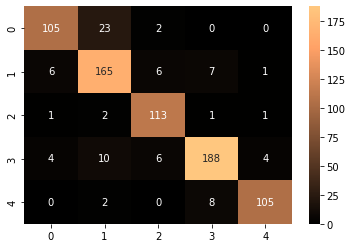

In [92]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, cmap=plt.cm.copper,fmt='g')
plt.show()

The above merged model gave a very similar accuracy score as when we used VADER, thus this model was discarded as it is more complicated

# Unsupervised (K-Means)

In [57]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
covid_unsup = covid.drop(columns=["OriginalTweet","Sentiment","scores","pred"])
covid_unsup.head()

,hashtag,count,mentions,compound
0,1,21,0,-0.2023
1,2,29,0,-0.4133
2,1,13,0,0.7579
3,11,35,0,-0.2500
4,11,25,0,0.0000


In [58]:
covid_unsup.shape

(3798, 4)

In [59]:
scaler = MinMaxScaler()
scaler.fit(covid_unsup)
covid_unsup_t = scaler.transform(covid_unsup)

Text(0.5, 1.0, 'Elbow Plot')

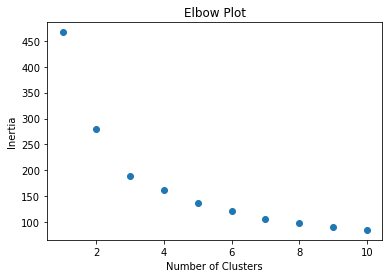

In [60]:
cluster_size = range(1,11)
cluster_inertia = [KMeans(n_clusters = k, n_init = 10, init = 'k-means++', max_iter = 300, random_state = 20764471)
                   .fit(covid_unsup_t).inertia_ 
                   for k in cluster_size]
plt.scatter(cluster_size, cluster_inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot')

In [61]:
covid_3clusters = KMeans(n_clusters = 3, n_init = 10, init = 'k-means++', max_iter = 300, random_state = 20764471)
covid_3clusters.fit(covid_unsup_t)
covid_3clusters.inertia_

189.89421520261178

<AxesSubplot:title={'center':'hashtag'}, xlabel='[Cluster]'>

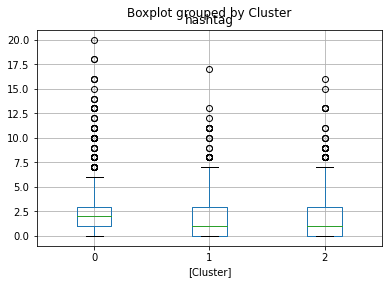

In [62]:
covid_unsup["Cluster"] = covid_3clusters.labels_
covid_unsup.boxplot(column=['hashtag'],by=['Cluster'])

<AxesSubplot:title={'center':'hashtag'}, xlabel='[Cluster]'>

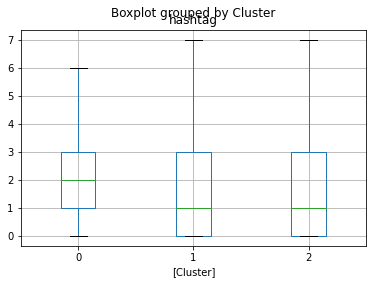

In [63]:
covid_unsup.boxplot(column=['hashtag'],by=['Cluster'],showfliers=False)

<AxesSubplot:title={'center':'count'}, xlabel='[Cluster]'>

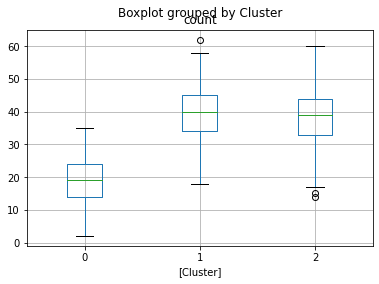

In [64]:
covid_unsup.boxplot(column=['count'],by=['Cluster'])

<AxesSubplot:title={'center':'mentions'}, xlabel='[Cluster]'>

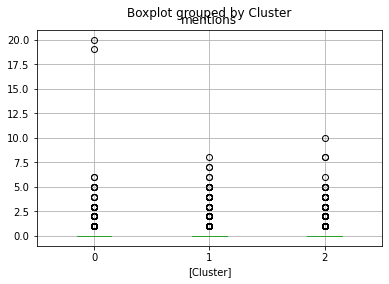

In [65]:
covid_unsup.boxplot(column=['mentions'],by=['Cluster'])

<AxesSubplot:title={'center':'mentions'}, xlabel='[Cluster]'>

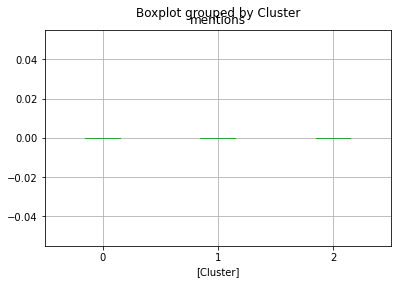

In [66]:
covid_unsup.boxplot(column=['mentions'],by=['Cluster'],showfliers=False)

<AxesSubplot:title={'center':'compound'}, xlabel='[Cluster]'>

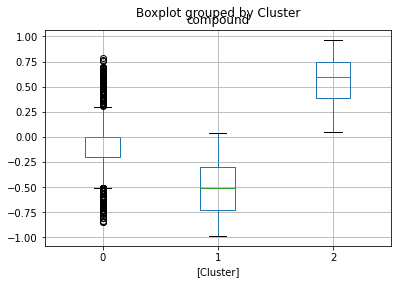

In [67]:
covid_unsup.boxplot(column=['compound'],by=['Cluster'])

In [ ]:
x = covid_unsup['hashtag']
y = covid_unsup['count']
z = covid_unsup['compound']
c = covid_unsup['Cluster']

ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=c)

# Topic Modelling

In [ ]:
coherence_values = []
model_list = []
for i in range(1,11):
    model = LsiModel(corpus_tfidf, num_topics=i, id2word = dictionary)  # train model
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

In [ ]:
x = range(1, 11)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lsamodel = LsiModel(corpus_tfidf, num_topics=5, id2word = dictionary)
lsamodel.print_topics(num_topics=3, num_words=3)

In [ ]:
coherence_values = []
model_list = []
for i in range(1,11):
    model = ldamodel.LdaModel(corpus_tfidf, num_topics=i, id2word = dictionary, random_state=20764471)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

x = range(1, 11)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lda = ldamodel.LdaModel(corpus_tfidf, num_topics=10, id2word = dictionary)
lda.print_topics(num_topics=3, num_words=3)

In [ ]:
tweets2 = pd.read_csv("tweets_large.csv", encoding = "latin")
tweets2 = tweets2[0:100000]
tweets2.columns = ['0','ID', 'Time', 'Query', 'User', 'Tweet']
tweets2.head()

In [ ]:
tweets = tweets2['Tweet']
filters = [lambda x: x.lower(), remove_stopwords, strip_tags, strip_punctuation, strip_numeric, strip_multiple_whitespaces, strip_short]
tokens = [preprocess_string(doc, filters) for doc in tweets]

In [ ]:
p = PorterStemmer()
tokens = [[p.stem(i) for i in j] for j in tokens]

In [ ]:
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(doc) for doc in tokens]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [ ]:
coherence_values = []
model_list = []
for i in range(1,11):
    model = LsiModel(corpus_tfidf, num_topics=i, id2word = dictionary)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())
    
x = range(1, 11)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lsamodel = LsiModel(corpus_tfidf, num_topics=9, id2word = dictionary)
lsamodel.print_topics(num_topics=9, num_words=10)

In [ ]:
coherence_values = []
model_list = []
for i in range(1,11):
    model = ldamodel.LdaModel(corpus_tfidf, num_topics=i, id2word = dictionary, random_state=20764471)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokens, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

x = range(1, 11)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
lda = ldamodel.LdaModel(corpus_tfidf, num_topics=8, id2word = dictionary)
lda.print_topics(num_topics=8, num_words=10)

# Finding similar tweets

Create tweet database

In [89]:
tweet_db = covid.drop(columns=["Sentiment","scores","pred"])
tweet_db["Rank"] = xgb.predict(tweet_db.drop(columns=["OriginalTweet"]))
tweet_db["Cluster"] = covid_3clusters.labels_
tweet_db = tweet_db.drop(columns=["hashtag","count","mentions","compound"])
tweet_db.head()

,OriginalTweet,Rank,Cluster
0,TRENDING: New Yorkers encounter empty supermar...,-0.450985,0
1,When I couldn't find hand sanitizer at Fred Me...,-0.480112,1
2,Find out how you can protect yourself and love...,0.936870,0
3,#Panic buying hits #NewYork City as anxious sh...,-0.469445,1
4,#toiletpaper #dunnypaper #coronavirus #coronav...,0.001942,0


Write new tweet about covid

In [200]:
new_tweet1 = "This pandemic is horrible! I wish someone would hurry up and invent a vaccine @Pfizer @Moderna"
new_tweet2 = "I am having a great time despite the pandemic :) Still many ways to have fun safely"
new_tweet3 = "Things are sorta okay I guess. Work from home is nice but hard to find things in stores #meh #whatever"

In [206]:
def find_similar(tweet, bycluster=False):
    # features
    hashtag  = tweet.count('#')
    count  = len(tweet.split())
    mentions  = tweet.count('@')
    compound = sid.polarity_scores(tweet)["compound"]
    data = pd.DataFrame([[hashtag,count,mentions,compound]],
                        columns=['hashtag','count','mentions','compound'])
    
    # predict cluster
    cluster = covid_3clusters.predict(data)[0]
    
    # predict ranking score
    rank = xgb.predict(data)[0]
    
    # only look within cluster if set
    within_cluster = tweet_db 
    if bycluster: 
        within_cluster = tweet_db[tweet_db.Cluster==cluster]
    
    # find 3 closest tweets by rank
    closest_tweets = within_cluster.iloc[(within_cluster['Rank']-rank).abs().argsort()[:3]]
    closest_tweets_bodies = closest_tweets["OriginalTweet"].tolist()
    
    for number, tweet in enumerate(closest_tweets_bodies):
        nl = '\n'
        print(f"Tweet {number+1}: {tweet}{nl}")

In [202]:
find_similar(new_tweet1)




Tweet 2: Russia dropping oil prices to screw up U.S. drilling &amp; fracking.  China dumps WuFlu on U.S.  All in hopes to dismantle our economy!  Do not forget trump said its better to deal with us before elections than after! Bad for xi n china! #coronavirus #Covid_19 #Trump #Trump2020 

Tweet 3: Coronavirus Panic: Toilet Paper Is the Peoples Vaccine  #toiletpaper #coronavirus #covid19 



In [203]:
find_similar(new_tweet2)

Tweet 1: Is it better to shop at the grocery store myself or order delivery? Which is safer? #coronavirus

Tweet 2: We'd like to thank grocery store employees and everyone else working hard to serve their communities during the novel #coronavirus outbreak.  

Tweet 3: Can we get a tax break or a Medal of Freedom for the grocery store employees this year? #coronavirus



In [204]:
find_similar(new_tweet3)







#Covid_19

Tweet 2: The person who stereotyped irish people as laidback and chill clearly hasn't stepped into a supermarket in the midst of a storm or a pandemic. If you are gonna do your shop in the coming days, get what you need, and be mindful of others. #Covid_19

Tweet 3: In every sphere, from travel and aviation to shipping and transport as well as oil prices and capital markets, economies around the world are seeing sharp downswings as a result of the fallout from the efforts to contain the spread of the coronavirus.#Covid_19



In [207]:
find_similar(new_tweet1,bycluster=True)

Tweet 1: Russia dropping oil prices to screw up U.S. drilling &amp; fracking.  China dumps WuFlu on U.S.  All in hopes to dismantle our economy!  Do not forget trump said its better to deal with us before elections than after! Bad for xi n china! #coronavirus #Covid_19 #Trump #Trump2020 









Tweet 3: #CoronaVirus #COVID_19 People are starting to become frightened and to do #PanicShopping. Many shelves, meanwhile, turn empty as #goods are sold. #FaceMasks &amp; disinfection liquid are sold out, or they are sold for exorbitant prices! #Blockchain #CryptoNews 



In [208]:
find_similar(new_tweet2,bycluster=True)







#Covid_19

Tweet 2: If the mid-#wales #population is wiped out by #coronavirus #COVID19 atleast the homes will be full of #cat #dog food. Mind you they're going to have to evolve extremely quickly to be able to open the sachets and cans! As soon as we can put stock on #supermarket shelves it goes







#coronavirus #FlattenTheCurve #Friday13th #fail



In [209]:
find_similar(new_tweet3,bycluster=True)







#Covid_19

Tweet 2: If the mid-#wales #population is wiped out by #coronavirus #COVID19 atleast the homes will be full of #cat #dog food. Mind you they're going to have to evolve extremely quickly to be able to open the sachets and cans! As soon as we can put stock on #supermarket shelves it goes







#coronavirus #FlattenTheCurve #Friday13th #fail

